$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\def\lc{\left\lceil}$$
$$\def\rc{\right\rceil}$$
# Quantum Approximate Optimization Algorithm (QAOA)

Mathematical optimization is a common problem which deals with finding the optimal solution to a problem. Specifically combinatorial optimization is notoriously difficult for classical computers since the optimal solution often requires exhaustively evaluating all combinations. For an input instance of $n$ data points and pair-wise combinations, this resolves in $\mathcal{O}(2^n)$ time complexity to solve.

There exists multiple algorithms for *quantum optimization*, e.g., quantum least squares fitting, quantum annealing, and more. In this notebook, we will take a deep dive into the variational method proposed by Farhi et al., namely, the Quantum Approximate Optimization Algorithm (QAOA).


---
The QAOA algorithm is at heart a variational algorithm based on the unitary operator $U(\beta, \gamma)$ which is parametrized by $\beta$ and $\gamma$. These parameters are used to prepare a quantum state $\ket{\psi(\beta, \gamma)}$ which we aim to optimize such that the state encodes the optimal solution to the defined problem. The problem is often defined as minimizing the cost function $C(x)$ where $x$ is a proposed solution (or quantum state) to the problem.

The unitary $U(\beta, \gamma)$ can be written in a specific form in terms of two other unitaries, which are

$$U(\beta) = e^{-i\beta H_B}$$

$$U(\gamma) = e^{-i\gamma H_P},$$

where $H_B$ is the so-called *mixing* Hamiltonian, and $H_P$ is the *problem* Hamiltonian (recall what a Hamiltonian matrix is from the previous notebook on the VQE algorithm). The searched for quantum state is prepared by applying these two unitaries as alternating blocks, applied $p$ times, such that

$$\ket{\psi(\beta, \gamma)} = \underbrace{U(\beta) U(\gamma)\cdots U(\beta) U(\gamma)}_{p \; \text{times}}\ket{\psi_0}$$

where $\ket{\psi_0}$ is a *suitable initial state*. But what is a suitable initial state? If you recall the for the VQE algorithm, this is what is called the *ansatz* of the algorithm. Picking the initial state is not trivial, and strongly depends on the optimization problem that is to be solved. However, often putting the input zero qubit states into equal superposition, $\ket{0} \to \ket{s} = \ket{\psi_0}$, suffices as the initial state for the algorithm.


---
After preparing the inital state $\ket{\psi_0}$ and applying the unitary operators $U(\beta)$ and $U(\gamma)$ a number of $p$ times the next step is to find the optimal parameters $\beta_{opt}$ and $\gamma_{opt}$. This is achieved by minimizing the expectation value of the problem Hamiltonian $H_P$, which is defined as

$$\bra{\psi(\beta_{opt}, \gamma_{opt})} H_P \ket{\psi(\beta_{opt}, \gamma_{opt})}.$$

The expectation value can be obtained by performing measurements in the Z-basis. An in-depth explanation for why we need to measure in the Z-basis can be found in the appendix. The short answer: 

>The cost function $C(x)$ which we are minimizing is mapped to the Hamiltonian $H$ that is *diagonal* in the computational basis. If we recall the Pauli operators, we know that the $Z$ operator is precisely a diagonal matrix. As such, $H$ can be written as a sum of weighted Pauli $Z$ operators (under a constraint).

A classical optimization algorithm is used to find the optimal parameters, e.g., gradient descent, and the following steps outline the general process of the QAOA algorithm:

1. Initialize $\beta$ and $\gamma$ to suitable *real* values.
2. Repeat until the convergence criteria is met:
    1. Prepare the state $\ket{\psi(\beta, \gamma)}$ using a quantum circuit.
    2. Measure the state in the standard basis.
    3. Compute the expectation value $\bra{\psi(\beta, \gamma)} H_P \ket{\psi(\beta, \gamma)}$
    4. Find a new set of parameters $\beta_{new}$ and $\gamma_{new}$ using a classical optimization algorithm
    5. Set the current parameters equal to the new parameters
   
Alright, cool! Now we have the theoretical knowledge needed to solve some practical problems.


## Max-Cut problem

Qiskit has an excellent tutorial for this problem, which I recommend checking out. However, we can solve this our own way now (hopefully). Nonetheless, the Max-Cut problem is defined as follows:

>Given a graph $G$, a set of vertices $V$, and a set of edges $E$, partition the vertices into two sets such that the number of edges between the sets is maximum.

We can directly see that when partitioning into two sets we have a total of $2^{|V|}$ number of possible combinations. 

We define the problem Hamiltonian $H_P$ based on $E$ such that it can be written as a sum of tensor products between the identity matrix $I$ and Pauli $Z$ operators between the edge pairs

$$H_P = \frac{1}{2}\sum_{(Z_i, Z_j)\in E}(Z_i\otimes Z_j)\bigotimes_{k\neq i,j} I_{k}.$$

The mixer Hamiltonian $H_B$ is to be written as a sum of tensor products between the identity matrix $I$ and Pauli $X$ operators for each vertex in $V$, accordingly

$$H_B = (X_0 \otimes \dots \otimes I_n) + \dots + (I_0 \otimes \dots \otimes X_n)$$

$$H_B = \sum_{i\in V}X_i\bigotimes_{k\neq i}I_k.$$

Because the individual terms in the summations commute, we can write the unitaries more elgantly as

$$U(H_B) = e^{-i\beta H_B} = e^{-i\beta X_0}\cdots e^{-i\beta X_n}$$

$$U(H_P) = e^{-i\gamma H_P} = e^{-i\gamma Z_0}\cdots e^{-i\gamma Z_n}.$$

Let's actually define a problem instance that we can work with, so assume we have a graph $G$ with the following set of vertices and edges:

$$V = \{0, 1, 2, 3, 4\}$$

$$E = \{(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)\}.$$

We will be using the Python library `networkx` for creating and visualzing our graph that we are seeking to find the Max-Cut of. To compute the expectation values of the partitions we will be using the `qiskit` library.


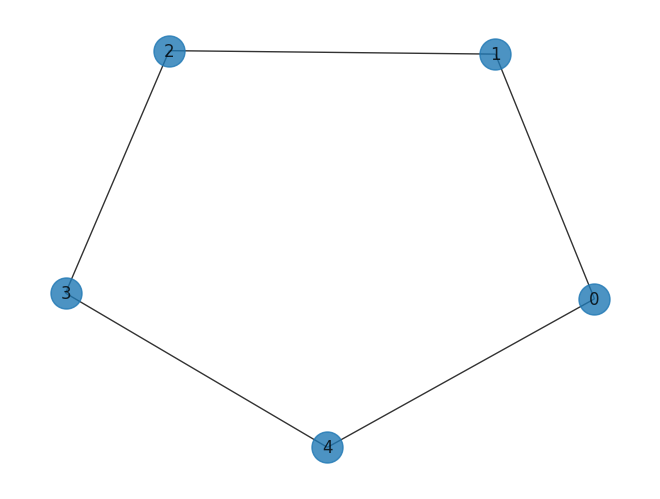

In [1]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)


In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter


### The mixing unitary $H_B$

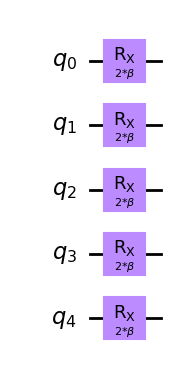

In [3]:
adjacency = nx.adjacency_matrix(G).todense()

nqubits = len(G.edges())

beta = Parameter('$\\beta$')
qc_mix = QuantumCircuit(nqubits)

for i in range(nqubits):
    qc_mix.rx(2 * beta, i)

display(qc_mix.draw('mpl'))


### The problem unitary $H_P$


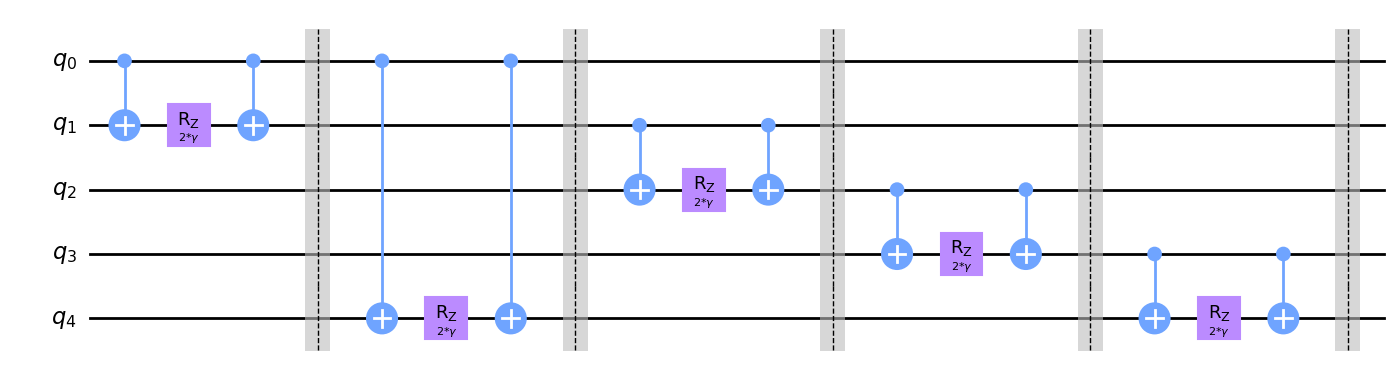

In [4]:
gamma = Parameter('$\\gamma$')
qc_p = QuantumCircuit(nqubits)

for pair in list(G.edges()):
    qc_p.rzz(2 * gamma, *pair)
    qc_p.barrier()

display(qc_p.decompose().draw('mpl'))
    

### The initial state $\ket{\psi_0}$

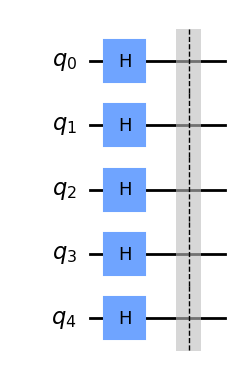

In [5]:
qc_0 = QuantumCircuit(nqubits)
for i in range(nqubits):
    qc_0.h(i)

qc_0.barrier()
display(qc_0.draw('mpl'))


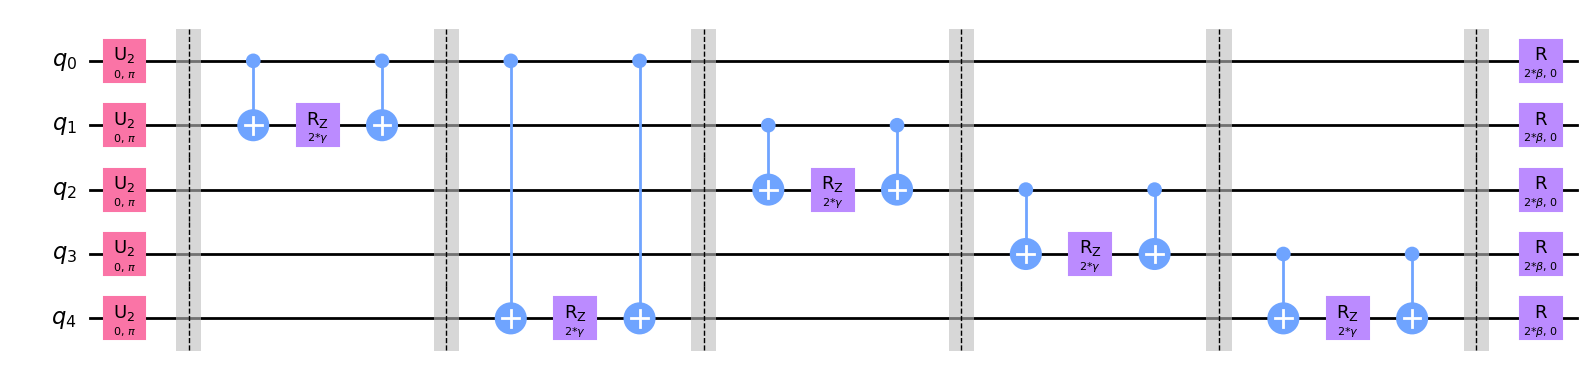

In [6]:
qc = QuantumCircuit(nqubits)
qubits = [i for i in range(nqubits)]
qc.append(qc_0, qubits)
qc.append(qc_p, qubits)
qc.append(qc_mix, qubits)

display(qc.decompose().decompose().draw('mpl'))


Above we can see what our constructed quantum circuit looks like. One note is that we are only performing the *alternating unitaries* $p=1$ times. But if we were to have more parameters $\theta$ for our circuit, we would have to apply $H_P$ and $H_B$ several times.

Let's make the example more modular, and executable.


In [7]:
def maxcut_obj(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
    
    return avg/sum_count

def create_QAOA_circuit(G, theta):
    nqubits = len(G.nodes())
    p = len(theta) // 2
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    for i in range(nqubits):
        qc.h(i)
    
    # Iteratively apply the unitaries
    for irep in range(p):
        
        # Problem Hamiltonian H_P
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], *pair)
        
        # Mixing Hamiltonian H_B
        for i in range(nqubits):
            qc.rx(2 * beta[irep], i)
    
    qc.barrier()
    qc.measure_all()
    
    return qc

def get_expectation(G, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def _execute_circuit(theta):
        qc = create_QAOA_circuit(G, theta)
        counts = backend.run(
            qc,
            seed_simulator=10,
            nshots=512
        ).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return _execute_circuit
    

In [8]:
from scipy.optimize import minimize

expectation = get_expectation(G)
result = minimize(
    expectation,
    [1.0, 1.0],
    method='COBYLA',
)

display(result)


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.744140625
       x: [ 1.970e+00  1.167e+00]
    nfev: 32
   maxcv: 0.0

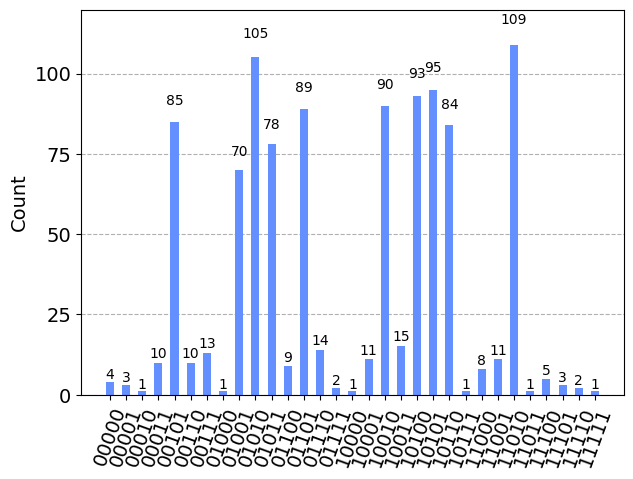

In [9]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_QAOA_circuit(G, result.x)
counts = backend.run(
    qc_res,
    seed_simulator=10,
).result().get_counts()

display(plot_histogram(counts))


## Portfolio Optimization

We aim to solve the following mean-variance portfolio optimization problem for $n$ assets:

$$\begin{split}\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}\end{split}$$

where $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, $\mu \in \mathbb{R}^n$ defines the expected returns for the assets, $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets, $q > 0$ controls the risk appetite of the decision maker, and $B$ denotes the budget, i.e., the number of assets to be selected out of $n$.

We assume the simplification that all assets have the same price (normalized to $1$), and the full budget $B$ has to be spent. The equality constraint $1^T x = B$ is mapped to the penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. We map the resulting problem to a Hamiltonian $H$ whose ground-state energy corresponds to the optimal solution $\ket{\psi_{\text{min}}}$.

Access to real-time stock-market data usually requires payment, but we can access historical (and adjusted) closing prices via Wikipedia and Nasdaq Data Link free of charge. Go to [this](https://data.nasdaq.com/sign-up) link and follow the free registration to get your API token.

Or you can access Yahoo Finance Data, without registering for an API token, see all available providers in the module `qiskit_finance.data_providers`.


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, RealAmplitudes
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit.opflow import PauliExpectation, CVaRExpectation
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *


In [19]:
# Define some utility functions for prettier printing.

def index_to_selection(i, n):
    s = '{0:b}'.format(i).rjust(n)
    x = np.array(
        [1 if s[i] == '1' else 0 for i in reversed(range(n))]
    )
    return x

def print_result(result, qp, n):
    selection = result.x
    value = result.fval
    print(f'Optimal: selection {selection}, value {value:.4f}')
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate
    if not isinstance(eigenstate, np.ndarray):
        eigenvector = eigenstate.to_matrix()
    
    probs = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probs))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    
    for i in i_sorted:
        x = index_to_selection(i, n)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        prob = probs[i]
        print(f'{x}\t{value:.4f}\t{prob:.6f}')


In [33]:
stocks = ['GOOG', 'AAPL', 'AMZN', 'MSFT', 'ATVI', 'TSLA', 'NVDA'
token = 'TOKEN'  # REPLACE THIS WITH YOUR TOKEN

try:
    wiki = WikipediaDataProvider(
        token=token,
        tickers=stocks,
        start=datetime.datetime(2016, 1, 1),
        end=datetime.datetime(2016, 3, 30),
    )
    wiki.run()
except QiskitFinanceError as err:
    print(err)
    print('Error retrieving data.')


A time-series similarity measure:
 [[1.00000000e+00 2.69050142e-05 1.12053104e-04 2.50299244e-05
  2.43809094e-05 3.21027803e-05 2.43010149e-05]
 [2.69050142e-05 1.00000000e+00 3.54064356e-05 3.59145703e-04
  2.59881724e-04 1.66172497e-04 2.51082685e-04]
 [1.12053104e-04 3.54064356e-05 1.00000000e+00 3.22291225e-05
  3.11610379e-05 4.49931408e-05 3.10306475e-05]
 [2.50299244e-05 3.59145703e-04 3.22291225e-05 1.00000000e+00
  9.40274666e-04 1.13607597e-04 8.34469264e-04]
 [2.43809094e-05 2.59881724e-04 3.11610379e-05 9.40274666e-04
  1.00000000e+00 1.01360796e-04 1.05642083e-02]
 [3.21027803e-05 1.66172497e-04 4.49931408e-05 1.13607597e-04
  1.01360796e-04 1.00000000e+00 9.99940529e-05]
 [2.43010149e-05 2.51082685e-04 3.10306475e-05 8.34469264e-04
  1.05642083e-02 9.99940529e-05 1.00000000e+00]]


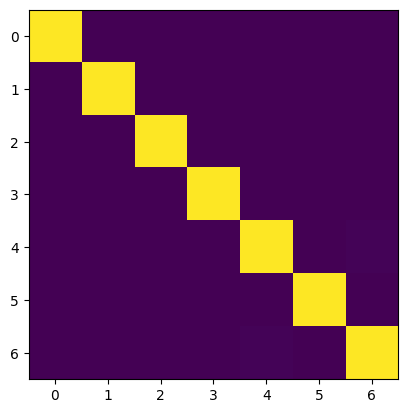

A covariance matrix:
 [[4.34309649e+02 5.28734486e+01 4.55090825e+02 2.73884152e+01
  2.57112702e+01 3.66255172e+02 3.46167159e+01]
 [5.28734486e+01 1.74792522e+01 5.43813995e+01 4.76757773e+00
  1.43250474e+00 8.06612695e+01 9.72633389e+00]
 [4.55090825e+02 5.43813995e+01 1.27847892e+03 2.99348276e+01
  6.97677488e+01 6.16895441e+02 4.36962956e+01]
 [2.73884152e+01 4.76757773e+00 2.99348276e+01 2.24215971e+00
  1.25242715e+00 2.70104820e+01 3.24764783e+00]
 [2.57112702e+01 1.43250474e+00 6.97677488e+01 1.25242715e+00
  5.25466024e+00 3.23501841e+01 8.02005648e-01]
 [3.66255172e+02 8.06612695e+01 6.16895441e+02 2.70104820e+01
  3.23501841e+01 5.94149482e+02 5.13547510e+01]
 [3.46167159e+01 9.72633389e+00 4.36962956e+01 3.24764783e+00
  8.02005648e-01 5.13547510e+01 7.74731558e+00]]


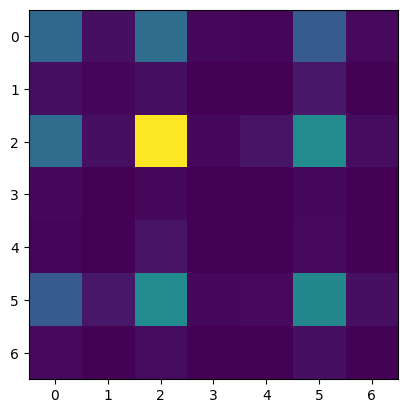

In [34]:
if wiki._data:
    rho = wiki.get_similarity_matrix()
    print(f'A time-series similarity measure:\n {rho}')
    display(plt.imshow(rho))
    plt.show()
    
    cov = wiki.get_covariance_matrix()
    print(f'A covariance matrix:\n {cov}')
    display(plt.imshow(cov))
    plt.show()


The underlying evolution of stock prices:


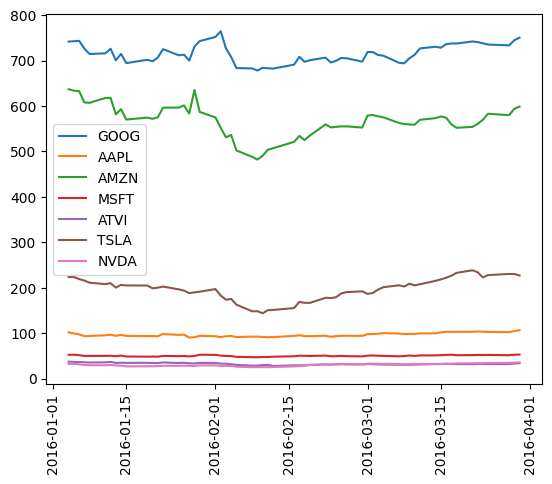

GOOG
Date
2016-01-04    741.84
2016-01-05    742.58
2016-01-06    743.62
2016-01-07    726.39
2016-01-08    714.47
2016-01-11    716.03
2016-01-12    726.07
2016-01-13    700.56
2016-01-14    714.72
2016-01-15    694.45
2016-01-19    701.79
2016-01-20    698.45
2016-01-21    706.59
2016-01-22    725.25
2016-01-25    711.67
2016-01-26    713.04
2016-01-27    699.99
2016-01-28    730.96
2016-01-29    742.95
2016-02-01    752.00
2016-02-02    764.65
2016-02-03    726.95
2016-02-04    708.01
2016-02-05    683.57
2016-02-08    682.74
2016-02-09    678.11
2016-02-10    684.12
2016-02-11    683.11
2016-02-12    682.40
2016-02-16    691.00
2016-02-17    708.40
2016-02-18    697.35
2016-02-19    700.91
2016-02-22    706.46
2016-02-23    695.85
2016-02-24    699.56
2016-02-25    705.75
2016-02-26    705.07
2016-02-29    697.77
2016-03-01    718.81
2016-03-02    718.85
2016-03-03    712.42
2016-03-04    710.89
2016-03-07    695.16
2016-03-08    693.97
2016-03-09    705.24
2016-03-10    712.82
201

In [35]:
if wiki._data:
    print('The underlying evolution of stock prices:')
    for i, s in enumerate(stocks):
        plt.plot(wiki._data[i], label=s)
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()
    
    for i, s in enumerate(stocks):
        print(s)
        print(wiki._data[i])


In [36]:
num_assets = len(stocks)

seed = 1
q = 0.5
B = num_assets // 2
P = num_assets

mu = wiki.get_period_return_mean_vector()
sigma = wiki.get_period_return_covariance_matrix()

portfolio = PortfolioOptimization(
    expected_returns=mu,
    covariances=sigma,
    risk_factor=q,
    budget=B
)
qp = portfolio.to_quadratic_program()
display(qp)


<QuadraticProgram: minimize 0.00014253511383004842*x_0^2 + 0.00016988834560426..., 7 variables, 1 constraints, 'Portfolio optimization'>

In [37]:
# Lets solve the problem, first classically.
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result, qp, num_assets)


Optimal: selection [1. 1. 0. 0. 0. 0. 1.], value -0.0022

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 0 0 1]	-0.0022	1.000000
[1 1 1 1 1 1 1]	16.2259	0.000000
[0 1 1 1 0 1 0]	1.0152	0.000000
[1 0 0 0 0 1 0]	1.0136	0.000000
[0 1 0 0 0 1 0]	1.0130	0.000000
[1 1 0 0 0 1 0]	-0.0006	0.000000
[0 0 1 0 0 1 0]	1.0150	0.000000
[1 0 1 0 0 1 0]	0.0015	0.000000
[0 1 1 0 0 1 0]	0.0008	0.000000
[1 1 1 0 0 1 0]	1.0151	0.000000
[0 0 0 1 0 1 0]	1.0136	0.000000
[1 0 0 1 0 1 0]	0.0000	0.000000
[0 1 0 1 0 1 0]	-0.0005	0.000000
[1 1 0 1 0 1 0]	1.0137	0.000000
[0 0 1 1 0 1 0]	0.0015	0.000000
[1 0 1 1 0 1 0]	1.0158	0.000000
[1 1 1 1 0 1 0]	4.0573	0.000000
[0 1 1 1 1 1 0]	4.0594	0.000000
[0 0 0 0 1 1 0]	1.0155	0.000000
[1 0 0 0 1 1 0]	0.0019	0.000000
[0 1 0 0 1 1 0]	0.0013	0.000000
[1 1 0 0 1 1 0]	1.0156	0.000000
[0 0 1 0 1 1 0]	0.0034	0.000000
[1 0 1 0 1 1 0]	1.0177	0.000000
[0 1 1 0 1 1 0]	1.0171	0.000000
[1 1 

In [38]:
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(
    backend=backend,
    seed_simulator=seed,
    seed_transpiler=seed
)
qaoa_mes = QAOA(
    optimizer=cobyla,
    reps=3,
    quantum_instance=quantum_instance,
)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result, qp, num_assets)


Optimal: selection [1. 1. 0. 0. 0. 0. 1.], value -0.0022

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 1 0 0 1]	1.0122	0.018557
[1 1 0 0 0 1 1]	1.0121	0.018544
[0 1 0 1 0 1 1]	1.0124	0.018541
[1 0 0 1 0 1 1]	1.0129	0.018480
[1 1 1 0 0 0 1]	1.0135	0.018403
[0 1 1 1 0 0 1]	1.0137	0.018393
[0 1 1 0 0 1 1]	1.0137	0.018391
[1 1 0 1 0 1 0]	1.0137	0.018378
[1 1 0 0 1 0 1]	1.0140	0.018348
[0 1 0 1 1 0 1]	1.0143	0.018344
[0 1 0 0 1 1 1]	1.0143	0.018340
[1 0 1 0 0 1 1]	1.0143	0.018338
[1 0 1 1 0 0 1]	1.0142	0.018335
[0 0 1 1 0 1 1]	1.0144	0.018325
[1 0 0 0 1 1 1]	1.0147	0.018281
[1 0 0 1 1 0 1]	1.0147	0.018279
[0 0 0 1 1 1 1]	1.0149	0.018273
[1 1 1 1 0 0 0]	1.0151	0.018245
[1 1 1 0 0 1 0]	1.0151	0.018238
[0 1 1 1 0 1 0]	1.0152	0.018222
[0 1 1 0 1 0 1]	1.0155	0.018193
[1 1 0 1 1 0 0]	1.0156	0.018188
[1 1 0 0 1 1 0]	1.0156	0.018179
[1 0 1 1 0 1 0]	1.0158	0.018172
[0 1 0 1 1 1 0]	1.0157	0.018169
[1 0 1 0 